In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

https://drive.google.com/file/d/1k2dCiBV-OTK0OSWCagsJPwbEytDky1sM/view?usp=sharing

In [2]:
! gdown --id 1k2dCiBV-OTK0OSWCagsJPwbEytDky1sM

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1k2dCiBV-OTK0OSWCagsJPwbEytDky1sM
From (redirected): https://drive.google.com/uc?id=1k2dCiBV-OTK0OSWCagsJPwbEytDky1sM&confirm=t&uuid=ea893d80-9527-488b-a831-72fbf5b78cab
To: /content/vacancies_2024.csv
100% 1.29G/1.29G [00:22<00:00, 56.9MB/s]


In [3]:
df = pd.read_csv("/content/vacancies_2024.csv", parse_dates=['published_at'])
df.head()

<ipython-input-3-f893133420ee>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/vacancies_2024.csv", parse_dates=['published_at'])


,name,key_skills,salary_from,salary_to,salary_currency,area_name,published_at
0,SAP R/3 functional consultant,NaN,NaN,NaN,NaN,Москва,2003-01-24 21:30:49+03:00
1,Broadcast encryption engineer,NaN,NaN,2000.0,USD,Южная Корея,2003-01-31 18:24:11+03:00
2,Embedded OS engineering manager,NaN,NaN,2000.0,USD,Москва,2003-01-31 18:25:43+03:00
3,Coordinator on Intellectual Property Projects,NaN,NaN,NaN,NaN,Москва,2003-02-12 10:40:50+03:00
4,Outsourcing Projects Coordinator,NaN,NaN,NaN,NaN,Москва,2003-02-14 16:31:06+03:00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6915297 entries, 0 to 6915296
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   name             object 
 1   key_skills       object 
 2   salary_from      float64
 3   salary_to        float64
 4   salary_currency  object 
 5   area_name        object 
 6   published_at     object 
dtypes: float64(2), object(5)
memory usage: 369.3+ MB


# Общая статистика

In [5]:
import requests
import pandas as pd
import xml.etree.ElementTree as ET

def get_all_currency():
    """
    Получает курсы валют из Центрального банка России (ЦБР) за период с января 2003 года по декабрь 2024 года.

    Функция отправляет HTTP-запросы к API ЦБР для получения данных о курсах валют и сохраняет их в словаре.
    Курс валюты сохраняется в формате:
    {
        'YYYY-MM': {
            'BYR': курс,
            'USD': курс,
            'EUR': курс,
            ...
        },
        ...
    }

    Returns:
        dict: Словарь с курсами валют, где ключами являются строки формата 'YYYY-MM',
              а значениями — словари с курсами валют.
    """
    month = 1
    year = 2003
    all_currency = 'BYR,USD,EUR,KZT,UAH,AZN,KGS,UZS,GEL'.split(',')
    len_cur = len(all_currency)
    result = {}
    while True:
        if year == 2024 and month == 12:
            break
        month_str = str(month)
        # print(f'{year}-{month_str}')
        if month < 10:
            month_str = '0' + month_str
        try:
          response = requests.get(f'https://cbr.ru/scripts/XML_daily.asp?date_req=01/{month_str}/{year}')
          result[f'{year}-{month_str}'] = {}
          root = ET.fromstring(response.content)
          for item in root.findall('Valute'):
              name = item.find('CharCode').text
              try:
                  index = all_currency.index(name) + 1
                  result[f'{year}-{month_str}'][name] = float(item.find('VunitRate').text.replace(',', '.'))
              except ValueError:
                  continue
        except Exception:
            continue
        if month == 12:
            month = 1
            year += 1
        else:
            month += 1
    return result

In [6]:
table_curr = get_all_currency()

In [7]:
def avg_salary(row):
  if row['salary_from'] and row['salary_to']:
    res = (row['salary_from'] + row['salary_to']) / 2

  elif row['salary_from']:
    res = row['salary_from']

  elif row['salary_to']:
    res = row['salary_to']
  else:
    return np.nan

  currency = row['salary_currency']
  try:
    if currency != 'RUR' and not pd.isnull(currency) and table_curr[row['data']][currency]:
      salary = table_curr[row['data']][currency] * res
      return salary
  except KeyError:
    return np.nan
  return res

In [8]:
def extract(value):
    data = str(value)[:7]
    return data

In [9]:
def extract_year(value):
    data = str(value)[:4]
    return int(data)

In [10]:
df_full = df.copy()

In [11]:
df_full['data'] = df_full['published_at'].apply(extract)

In [12]:
df_full['avg_salary'] = df_full.apply(avg_salary,axis=1)

In [13]:
df_full = df_full[df_full['avg_salary'] < 10_000_000]
df_full.shape

(1697612, 9)

In [14]:
df_full['year'] = df_full['published_at'].apply(extract_year)

In [15]:
df_full_salary = df_full[["name","avg_salary", "area_name",'year']].copy()

### Динамика уровня зарплат по годам

In [16]:
df_full_salary_pivot = df_full_salary.pivot_table(index='year', values=['avg_salary'])
df_full_salary_pivot = df_full_salary_pivot.reset_index()

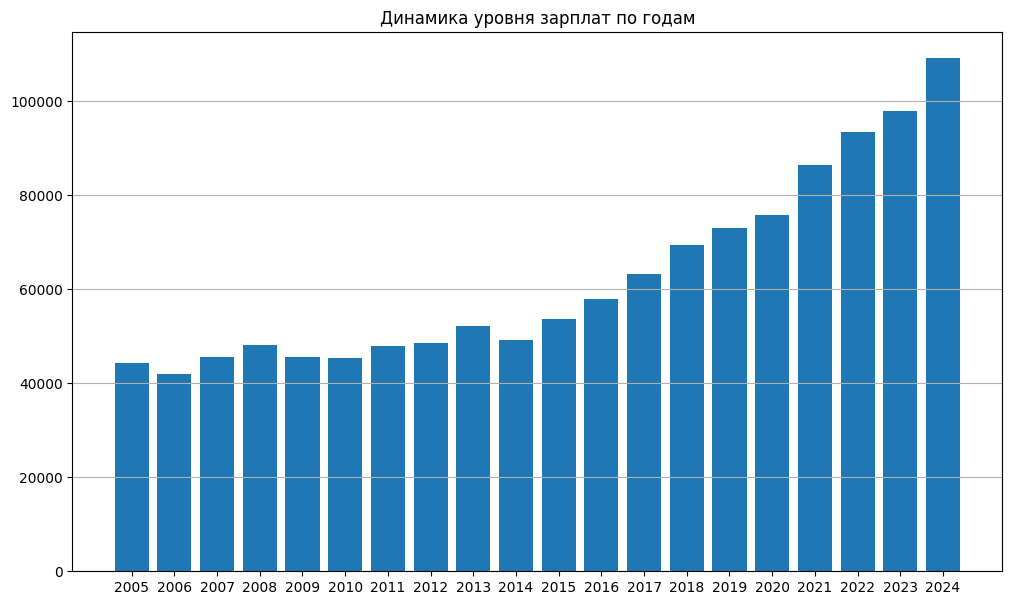

In [62]:
plt.figure(figsize=(12, 7))
plt.title("Динамика уровня зарплат по годам")
plt.bar(df_full_salary_pivot['year'],df_full_salary_pivot['avg_salary'])
plt.xticks(df_full_salary_pivot['year'])
plt.grid(axis='y')
plt.show()

### Динамика количества вакансий по годам

In [18]:
df_full_count_pivot = df_full_salary.pivot_table(index='year', values=['name'], aggfunc='count')
df_full_count_pivot = df_full_count_pivot.reset_index()

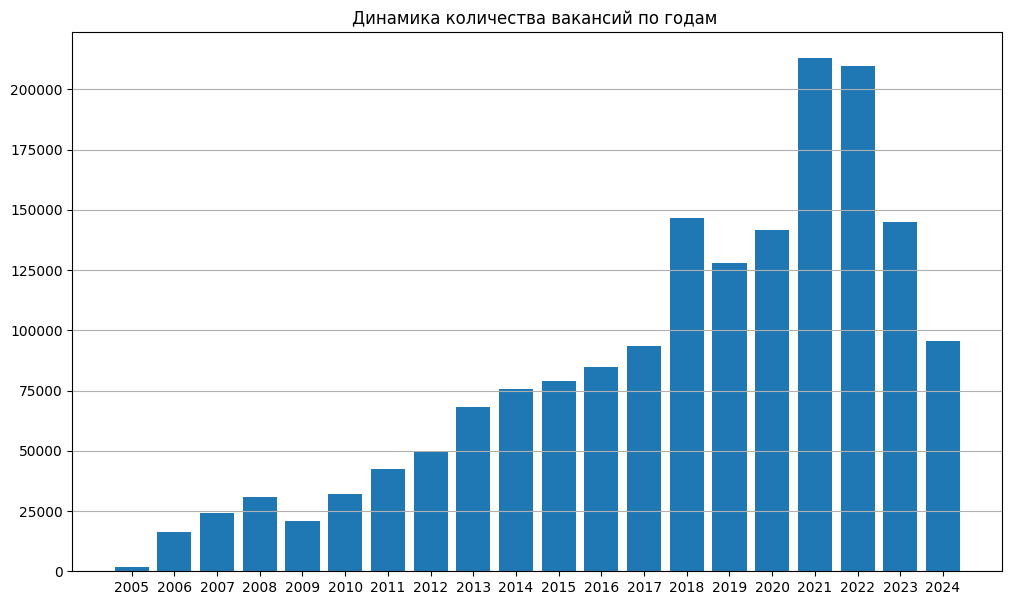

In [61]:
plt.figure(figsize=(12, 7))
plt.bar(df_full_count_pivot['year'],df_full_count_pivot['name'])

plt.xticks(df_full_count_pivot['year'])
plt.title("Динамика количества вакансий по годам")
plt.grid(axis='y')
plt.show()

### Уровень зарплат по городам

In [20]:
df_full_salary_level = df_full.pivot_table(index='area_name', values=['avg_salary', 'name'], aggfunc={'avg_salary':'mean', 'name':'count'}).reset_index().sort_values(by=["name",'avg_salary'], ascending=False).head(16)
df_full_salary_level

,area_name,avg_salary,name
2417,Москва,95090.904843,489977
3346,Санкт-Петербург,81911.626633,178729
2679,Новосибирск,80134.133512,42643
1470,Казань,67751.433228,37902
1134,Екатеринбург,76822.792921,37569
101,Алматы,55242.707061,36187
2559,Нижний Новгород,63659.753445,34718
1870,Краснодар,64967.902176,31748
3282,Ростов-на-Дону,57074.941467,30926
3338,Самара,63211.049291,22880


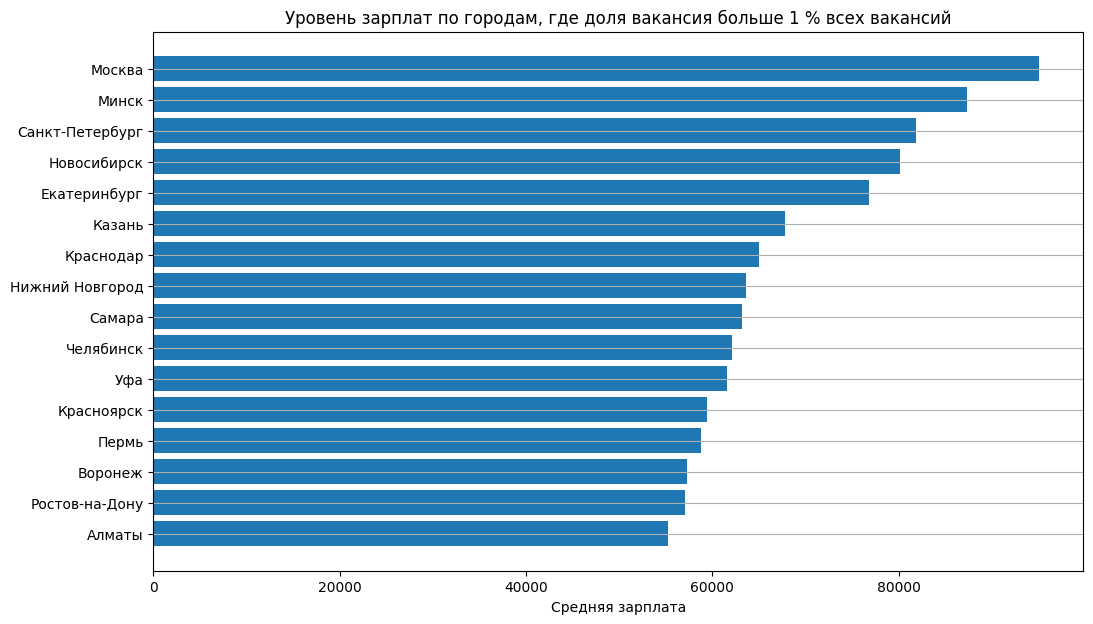

In [21]:
df_full_salary_level = df_full_salary_level.sort_values(by='avg_salary', ascending=True)
plt.figure(figsize=(12,7))
plt.barh(df_full_salary_level['area_name'], df_full_salary_level['avg_salary'])
plt.title("Уровень зарплат по городам, где доля вакансия больше 1 % всех вакансий")
plt.xlabel('Средняя зарплата')
plt.grid(axis='y');

### Доля вакансий по городам

In [22]:
df_full_salary_level_all = df_full.pivot_table(index='area_name', values=['avg_salary', 'name'], aggfunc={'avg_salary':'mean', 'name':'count'}).reset_index().sort_values(by=["name",'avg_salary'], ascending=False)

In [23]:
df_full_salary_level_all

,area_name,avg_salary,name
2417,Москва,95090.904843,489977
3346,Санкт-Петербург,81911.626633,178729
2679,Новосибирск,80134.133512,42643
1470,Казань,67751.433228,37902
1134,Екатеринбург,76822.792921,37569
...,...,...,...
3105,Пригородный,900.000000,1
3376,Свердловск,182.114050,1
18,Агдаш,55.000000,1
4133,Чегем Второй,40.000000,1


In [24]:
df_full_salary_level_head = df_full_salary_level_all.head(9)
other_cities_count = df_full_salary_level_all['name'].iloc[9:].sum()
other_city = pd.DataFrame({'area_name': ['Другие'], 'name': [other_cities_count]})

final_df = pd.concat([df_full_salary_level_head, other_city], axis=0)

final_df

,area_name,avg_salary,name
2417,Москва,95090.904843,489977
3346,Санкт-Петербург,81911.626633,178729
2679,Новосибирск,80134.133512,42643
1470,Казань,67751.433228,37902
1134,Екатеринбург,76822.792921,37569
101,Алматы,55242.707061,36187
2559,Нижний Новгород,63659.753445,34718
1870,Краснодар,64967.902176,31748
3282,Ростов-на-Дону,57074.941467,30926
0,Другие,NaN,777213


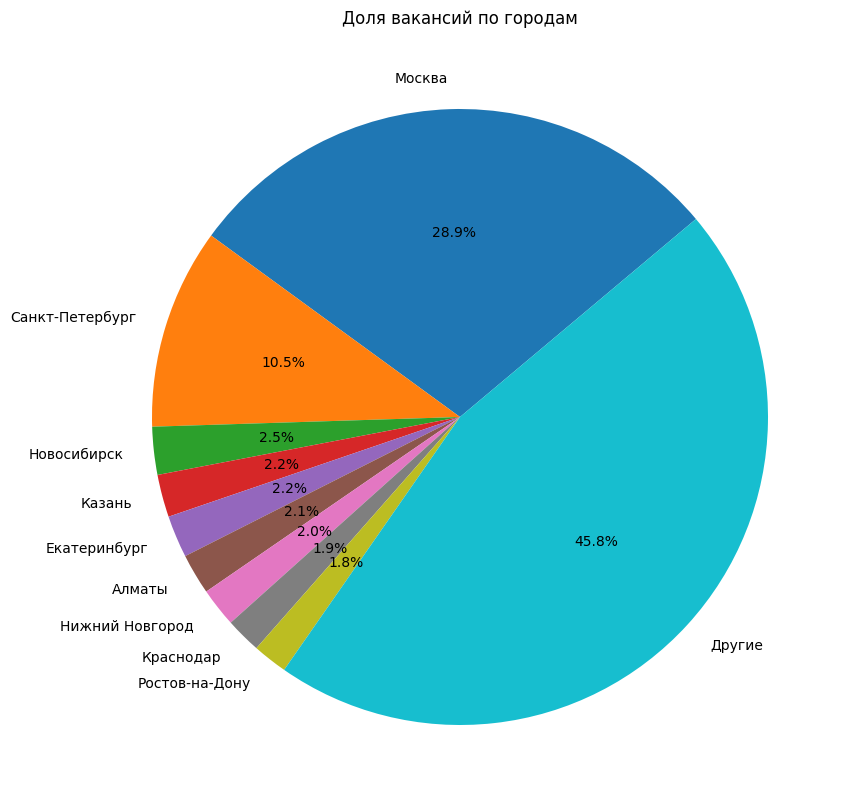

In [25]:
plt.figure(figsize=(15, 10))
plt.pie(final_df['name'], labels=final_df['area_name'], autopct='%1.1f%%', startangle=40)
plt.title("Доля вакансий по городам");

### ТОП-20 навыков по годам. Наиболее высокочастотные навыки

In [94]:
from collections import Counter
from itertools import islice

def top_skills(year):
    all_skills = df_full[(df_full['year'] == year) & (df_full['key_skills'].notna())]
    all_skills = all_skills['key_skills'].str.cat(sep='\n').split('\n')
    skill_frequency = Counter(all_skills)

    sorted_dict_desc = dict(sorted(skill_frequency.items(), key=lambda item: item[1], reverse=True))
    first_20_pairs = dict(islice(sorted_dict_desc.items(), 20))

    skills_frame = pd.DataFrame.from_dict(first_20_pairs, orient='index').reset_index()
    skills_frame.columns = ['skill', 'freq']
    skills_frame = skills_frame.sort_values(by='freq')

    plt.title(f"ТОП-20 навыков за {year} год")
    plt.barh(skills_frame['skill'], skills_frame['freq'])
    plt.xticks(rotation=45)
    plt.grid(axis='y');
    plt.show()

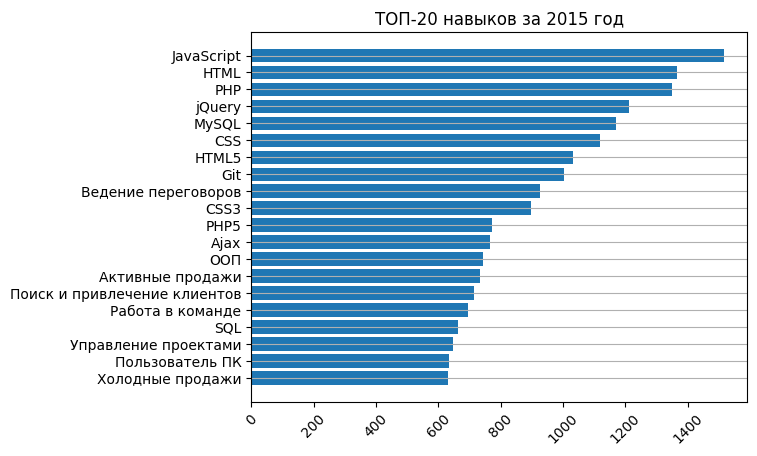

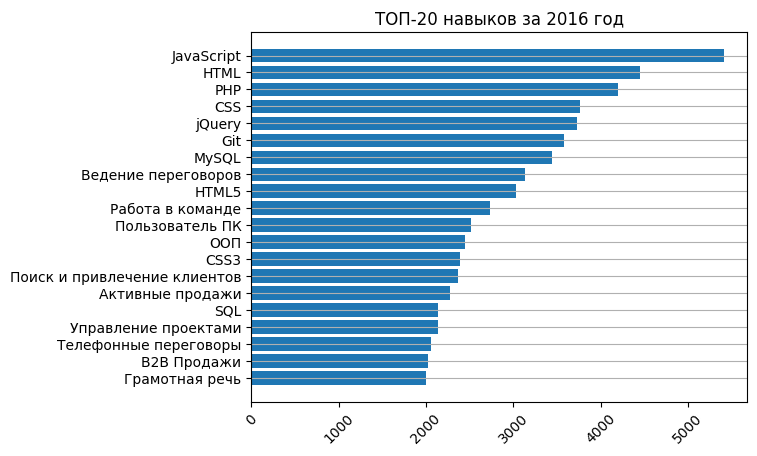

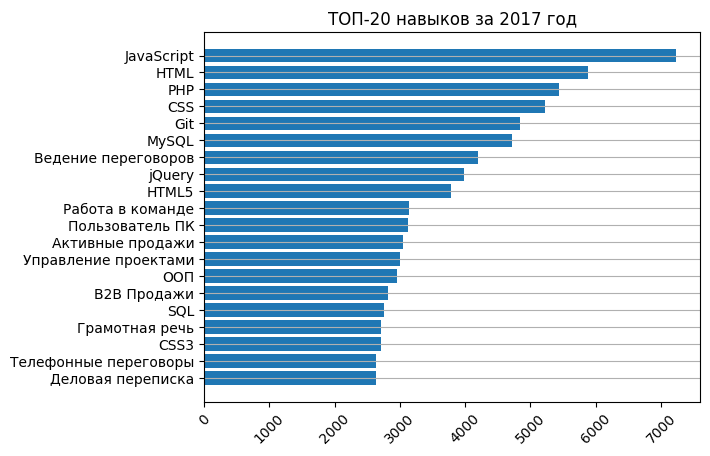

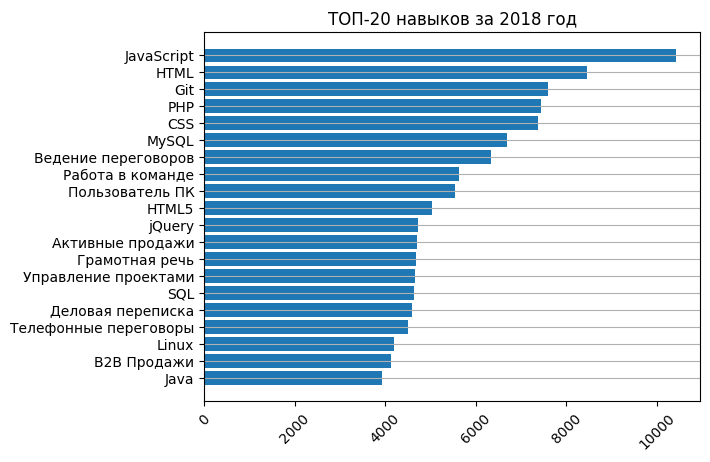

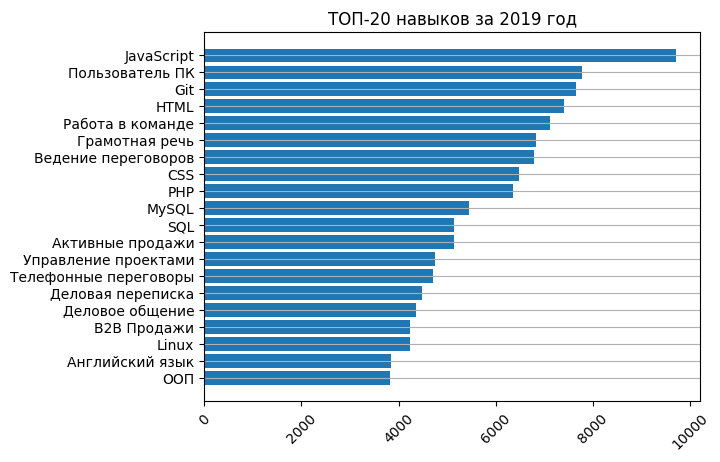

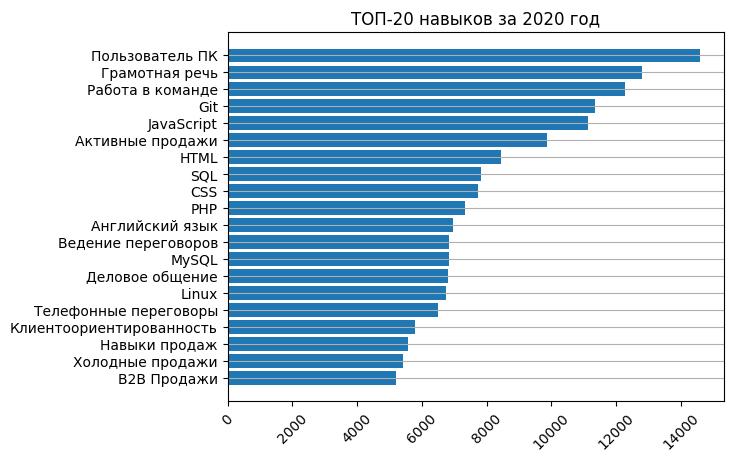

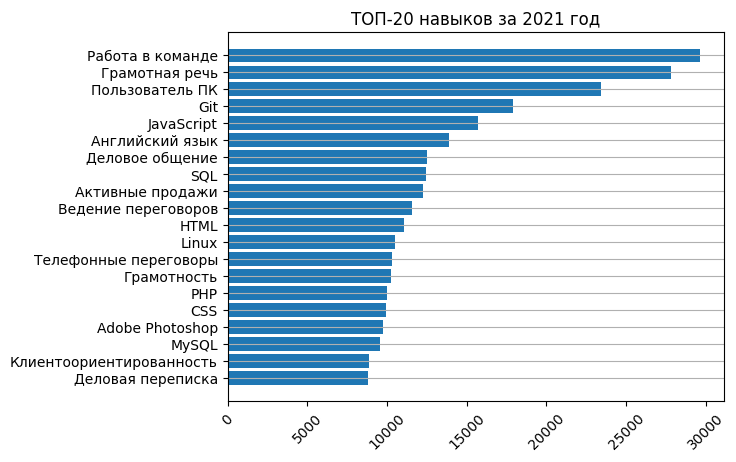

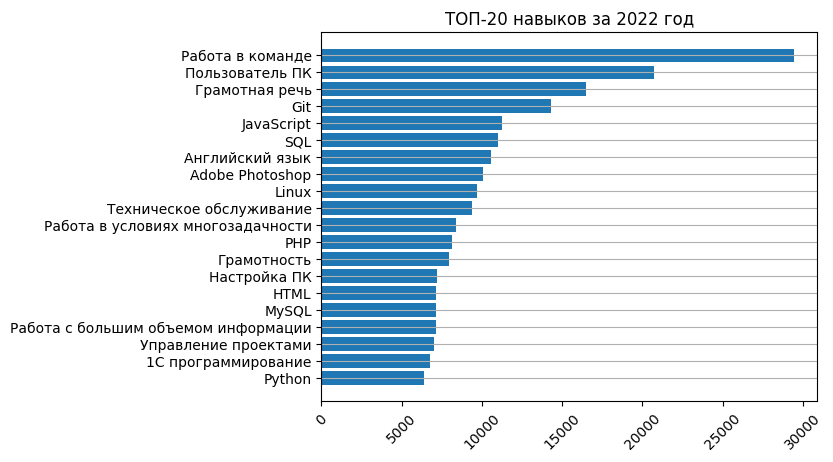

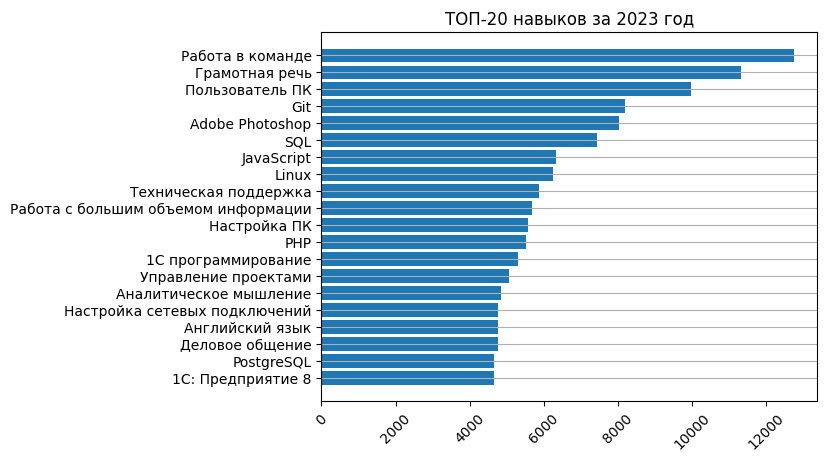

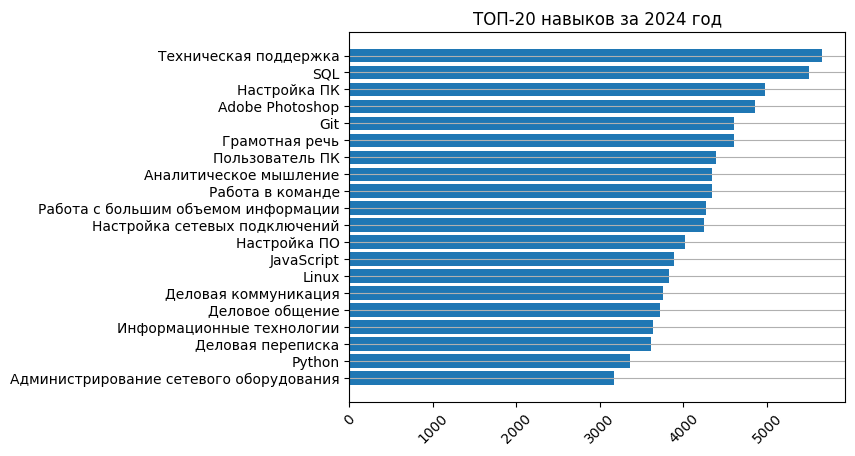

In [95]:
for i in range(2015, 2025):
  top_skills(i)

# Аналитика по профессии

In [27]:
df_copy = df.copy()

In [51]:
names = ['backend', 'бэкэнд', 'бэкенд', 'бекенд', 'бекэнд', 'back end', 'бэк энд', 'бэк енд', 'django', 'flask', 'laravel', 'yii', 'symfony']

df_copy = df_copy[df_copy['name'].str.lower().str.contains('|'.join(names))]
df_copy

,name,key_skills,salary_from,salary_to,salary_currency,area_name,published_at,data,avg_salary,year
188515,J2EE Back End Web Developer,NaN,1000.0,1500.0,USD,Воронеж,2009-01-12 15:05:00+03:00,2009-01,36739.5,2009
189834,PHP-разработчик (Symfony),NaN,40000.0,60000.0,RUR,Москва,2009-01-19 16:01:53+03:00,2009-01,50000.0,2009
193927,PHP-разработчик (Symfony Framework),NaN,40000.0,60000.0,RUR,Москва,2009-02-19 09:42:19+03:00,2009-02,50000.0,2009
195775,Написание морд сайтов на Django (Python),NaN,40000.0,50000.0,RUR,Москва,2009-03-06 16:56:52+03:00,2009-03,45000.0,2009
199123,"Web-программист: Python, Django",NaN,49000.0,71000.0,RUR,Москва,2009-04-01 17:22:55+04:00,2009-04,60000.0,2009
...,...,...,...,...,...,...,...,...,...,...
6912876,Senior Backend Developer (NodeJS),TypeScript\nJavaScript\nNodeJS\nRedis\nNestJS\...,400000.0,435000.0,RUR,Санкт-Петербург,2024-11-28 02:41:31+03:00,2024-11,417500.0,2024
6913345,Backend PHP-разработчик/1C-Битрикс (backend),NaN,120000.0,142000.0,RUR,Санкт-Петербург,2024-11-28 16:31:34+03:00,2024-11,131000.0,2024
6913379,PHP-программист Laravel + Elastic (Middle+),PHP+\nMySQL\nLaravel\nElasticSearch7\nDockerGi...,150000.0,200000.0,RUR,Москва,2024-11-28 13:50:10+03:00,2024-11,175000.0,2024
6914399,Backend-разработчик (PHP),PHP\nGit\nLinux\nАлгоритмы и структуры данных\...,80000.0,120000.0,RUR,Волгодонск,2024-11-29 11:26:37+03:00,2024-11,100000.0,2024


In [34]:
df_copy[['salary_from','salary_to']] = df_copy[['salary_from','salary_to']].map(lambda x: float(x))

In [35]:
df_copy['data'] = df_copy['published_at'].apply(extract)

In [36]:
df_copy['avg_salary'] = df_copy.apply(avg_salary,axis=1)

In [37]:
df_copy = df_copy[df_copy['avg_salary'] < 10_000_000]
df_copy.shape

(24613, 9)

In [38]:
df_copy['year'] = df_copy['published_at'].apply(extract_year)

<ipython-input-38-a6527b758dec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['year'] = df_copy['published_at'].apply(extract_year)


In [39]:
df_copy['name'].value_counts()

,count
name,
Backend-разработчик,661
Backend разработчик,552
Backend Developer,206
Backend-разработчик (PHP),188
Backend разработчик (PHP),176
...,...
Backend разработчик PHP/Laravel (junior / middle),1
Back-end Python/Django,1
Senior/Middle darajasidagi PHP Yii2 dasturchilarni,1


In [52]:
df_copy_salary = df_copy[["name","avg_salary", "area_name",'year']].copy()

## Востребованность

### Динамика уровня зарплат по годам для выбранной профессии

In [53]:
df_copy_salary_pivot = df_copy_salary.pivot_table(index='year', values=['avg_salary'], aggfunc='mean')
df_copy_salary_pivot = df_copy_salary_pivot.reset_index()

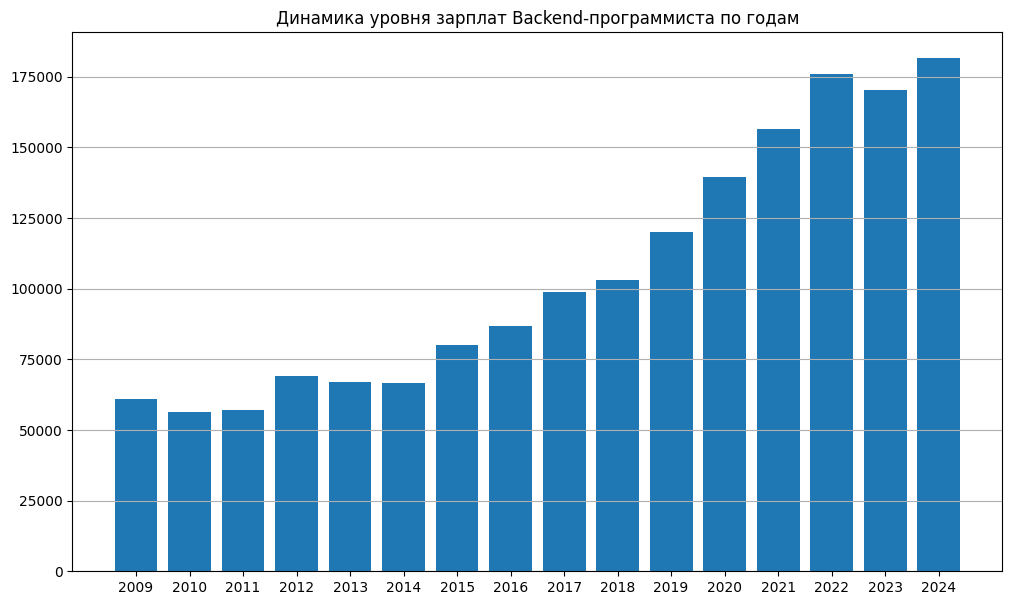

In [96]:
plt.figure(figsize=(12, 7))
plt.title("Динамика уровня зарплат Backend-программиста по годам")
plt.bar(df_copy_salary_pivot['year'],df_copy_salary_pivot['avg_salary'])
plt.xticks(df_copy_salary_pivot['year'])
plt.grid(axis='y')
plt.show()

### Динамика количества вакансий по годам для выбранной профессии

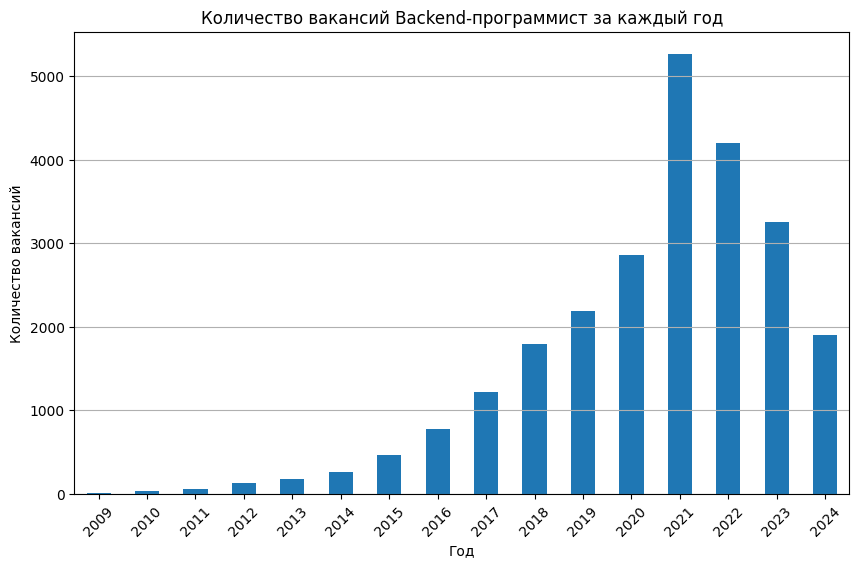

In [58]:
vacancies_per_year = df_copy['year'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
vacancies_per_year.plot(kind='bar')
plt.title('Количество вакансий Backend-программист за каждый год')
plt.xlabel('Год')
plt.ylabel('Количество вакансий')
plt.xticks(rotation=45)
plt.grid(axis='y')

## География

### Горизонтальная диаграмма - уровень зарплат по городам

In [59]:
df_copy_salary_level = df_copy.pivot_table(index='area_name', values=['avg_salary', 'name'], aggfunc={'avg_salary':'mean', 'name':'count'}).reset_index().sort_values(by=["name",'avg_salary'], ascending=False).head(16)
df_copy_salary_level

,area_name,avg_salary,name
177,Москва,177804.464854,7921
243,Санкт-Петербург,153312.693770,3165
197,Новосибирск,145323.968904,890
8,Алматы,97775.567383,846
92,Екатеринбург,138191.971168,837
111,Казань,148694.361706,598
143,Краснодар,120729.876276,537
174,Минск,144115.076351,487
275,Ташкент,105752.341219,450
189,Нижний Новгород,145745.089564,442


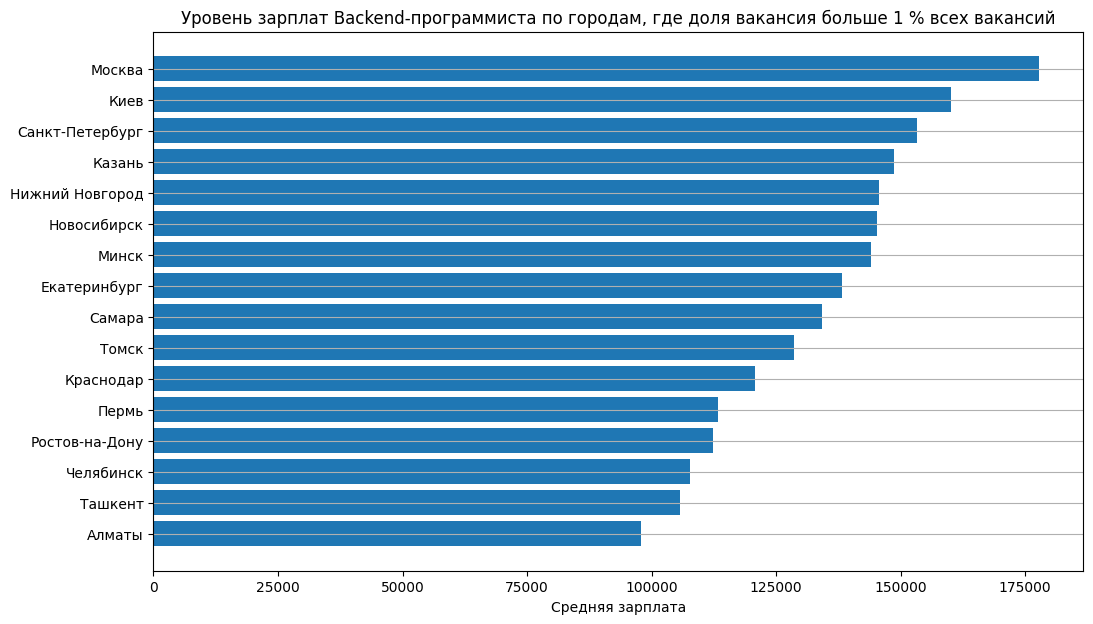

In [97]:
df_copy_salary_level = df_copy_salary_level.sort_values(by='avg_salary', ascending=True)
plt.figure(figsize=(12,7))
plt.barh(df_copy_salary_level['area_name'], df_copy_salary_level['avg_salary'])
plt.title("Уровень зарплат Backend-программиста по городам, где доля вакансия больше 1 % всех вакансий")
plt.xlabel('Средняя зарплата')
plt.grid(axis='y');

### Доля вакансий по городам для выбранной профессии (в порядке убывания)

In [64]:
df_copy_salary_level_all = df_copy.pivot_table(index='area_name', values=['avg_salary', 'name'], aggfunc={'avg_salary':'mean', 'name':'count'}).reset_index().sort_values(by=["name",'avg_salary'], ascending=False)

In [65]:
df_copy_salary_level_head = df_copy_salary_level_all.head(9)
other_cities_count = df_copy_salary_level_all['name'].iloc[9:].sum()
other_city = pd.DataFrame({'area_name': ['Другие'], 'name': [other_cities_count]})

final_df = pd.concat([df_copy_salary_level_head, other_city], axis=0)

final_df

,area_name,avg_salary,name
177,Москва,177804.464854,7921
243,Санкт-Петербург,153312.693770,3165
197,Новосибирск,145323.968904,890
8,Алматы,97775.567383,846
92,Екатеринбург,138191.971168,837
111,Казань,148694.361706,598
143,Краснодар,120729.876276,537
174,Минск,144115.076351,487
275,Ташкент,105752.341219,450
0,Другие,NaN,8882


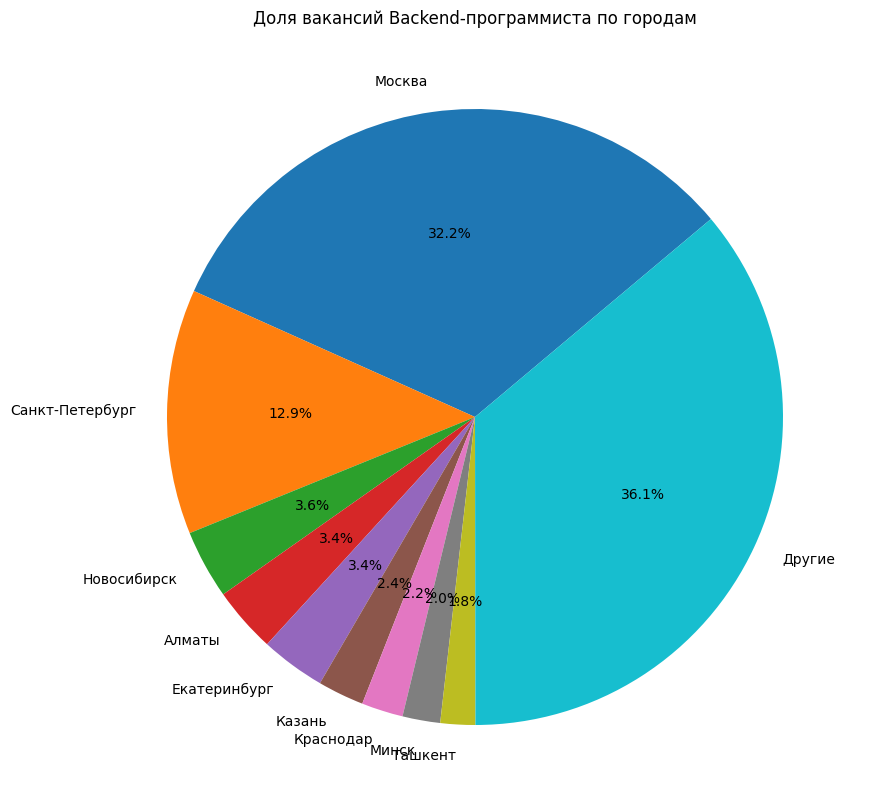

In [98]:
plt.figure(figsize=(15, 10))
plt.pie(final_df['name'], labels=final_df['area_name'], autopct='%1.1f%%', startangle=40)
plt.title("Доля вакансий Backend-программиста по городам");

## Навыки

### ТОП-20 навыков по годам для выбранной профессии. Наиболее высокочастотные навыки (по анализу поля: key_skills).

In [68]:
from collections import Counter
all_skills = df_copy[df_copy['key_skills'].notna()]
all_skills = df_copy['key_skills'].str.cat(sep='\n').split('\n')
skill_frequency = Counter(all_skills)

In [69]:
sorted_dict_desc = dict(sorted(skill_frequency.items(), key=lambda item: item[1], reverse=True))

In [90]:
from itertools import islice
def top_skills_back(year):
    all_skills = df_copy[(df_copy['year'] == year) & (df_copy['key_skills'].notna())]
    all_skills = all_skills['key_skills'].str.cat(sep='\n').split('\n')
    skill_frequency = Counter(all_skills)

    sorted_dict_desc = dict(sorted(skill_frequency.items(), key=lambda item: item[1], reverse=True))
    first_20_pairs = dict(islice(sorted_dict_desc.items(), 20))

    skills_frame = pd.DataFrame.from_dict(first_20_pairs, orient='index').reset_index()
    skills_frame.columns = ['skill', 'freq']
    skills_frame = skills_frame.sort_values(by='freq')
    plt.title(f"ТОП-20 навыков для Backend-программиста за {year}")
    plt.barh(skills_frame['skill'], skills_frame['freq'])
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()


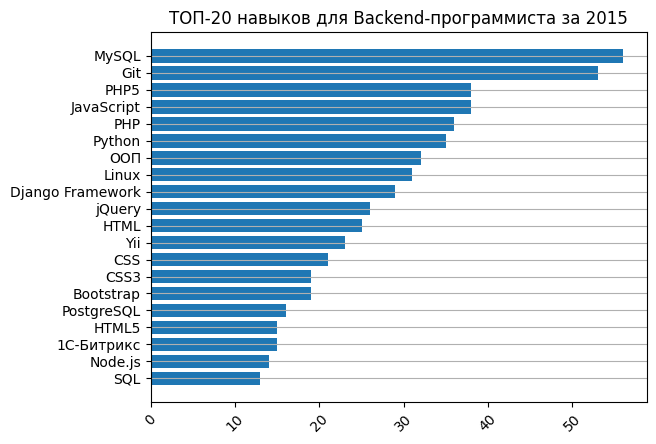

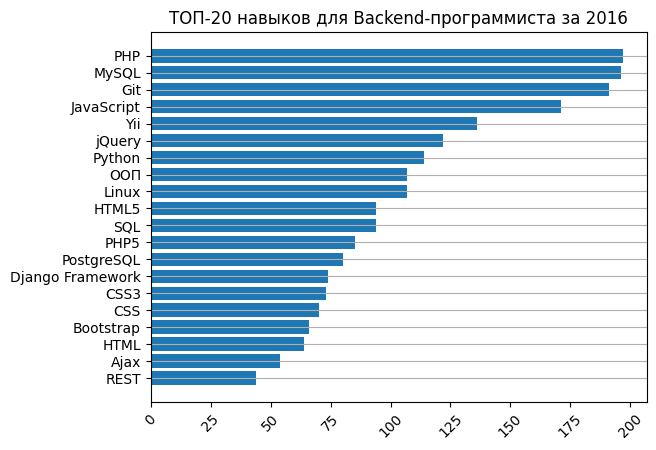

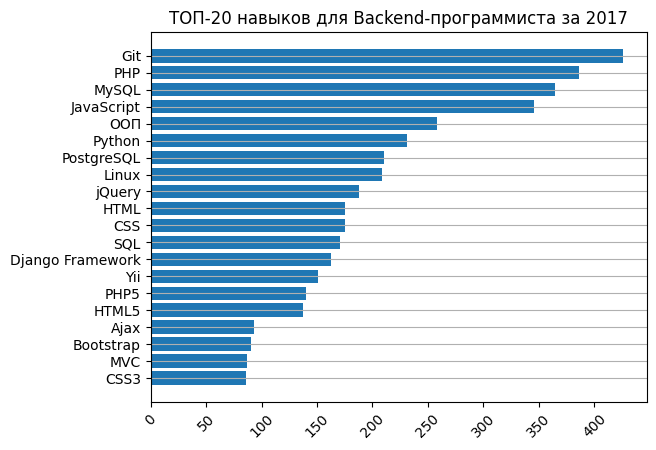

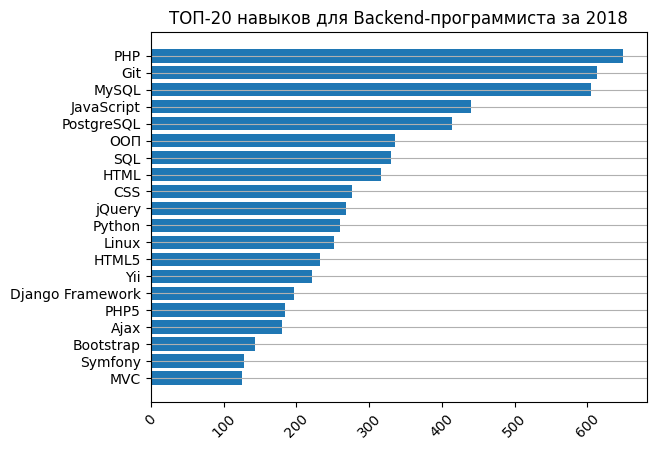

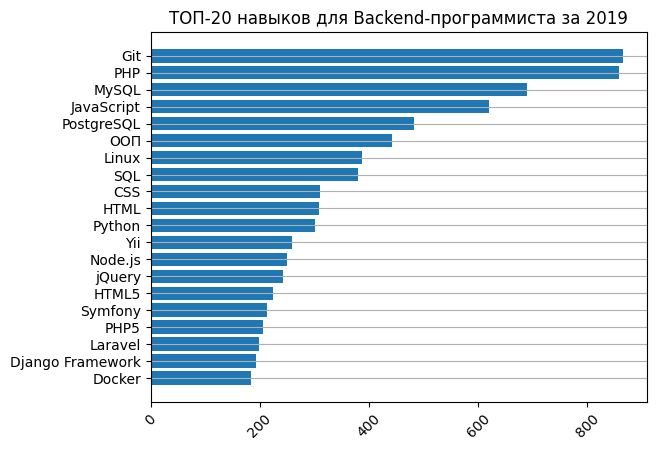

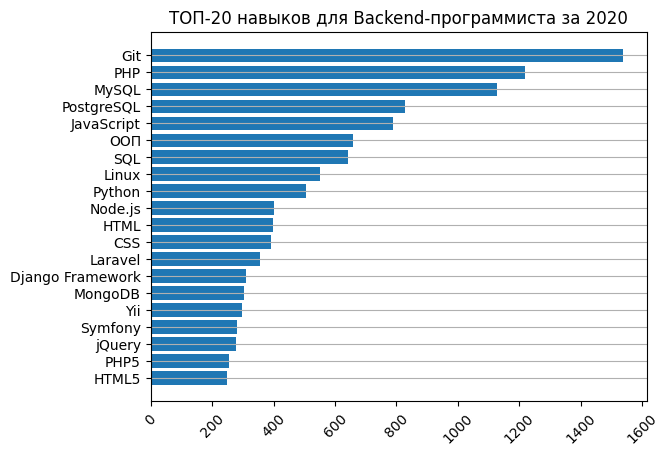

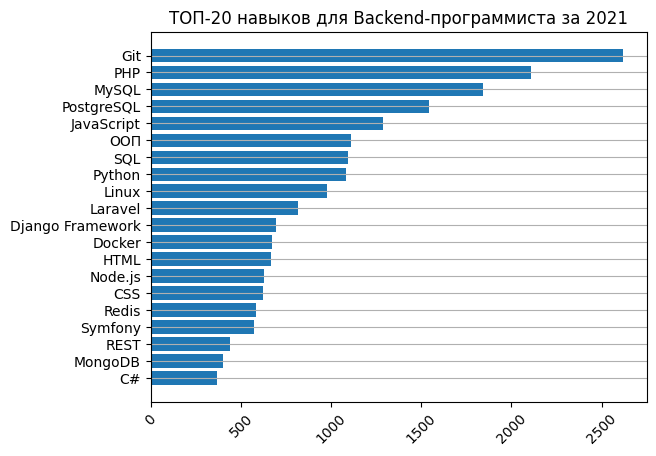

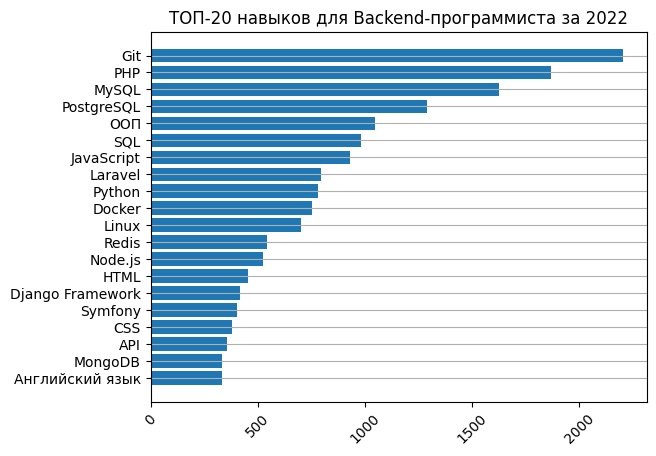

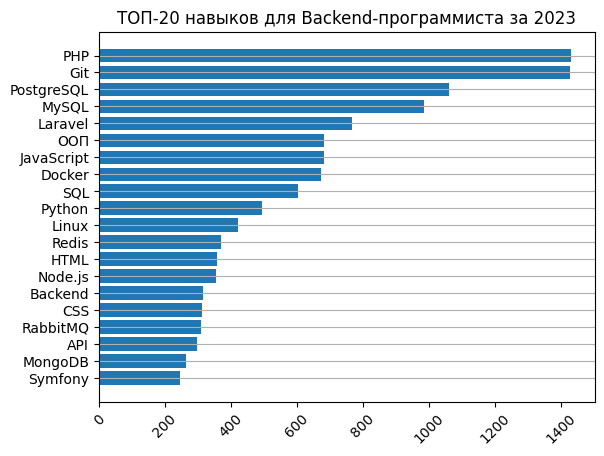

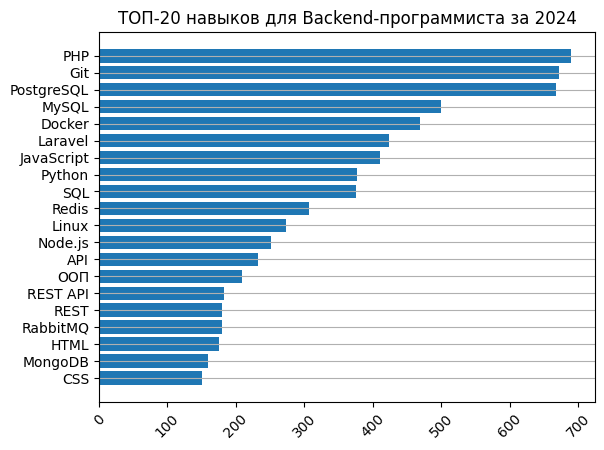

In [91]:
for i in range(2015, 2025):
  top_skills_back(i)